# Testing `causallib` plots

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Previous versions of causallib might produce lots of warnings when evaluating outcomes due to faulty argument passing
import warnings

warnings.filterwarnings("ignore")

In [3]:
from sklearn.linear_model import LinearRegression, LogisticRegression

from causallib.datasets import load_nhefs
from causallib.estimation import AIPW, IPW, StratifiedStandardization
from causallib.evaluation import evaluate, plot_evaluation_results

In [4]:
data = load_nhefs()
data.X.head()

,age,race,sex,smokeintensity,smokeyrs,wt71,active_1,active_2,education_2,education_3,education_4,education_5,exercise_1,exercise_2,age^2,wt71^2,smokeintensity^2,smokeyrs^2
0,42,1,0,30,29,79.04,0,0,0,0,0,0,0,1,1764,6247.3216,900,841
1,36,0,0,20,24,58.63,0,0,1,0,0,0,0,0,1296,3437.4769,400,576
2,56,1,1,20,26,56.81,0,0,1,0,0,0,0,1,3136,3227.3761,400,676
3,68,1,0,3,53,59.42,1,0,0,0,0,0,0,1,4624,3530.7364,9,2809
4,40,0,0,20,19,87.09,1,0,1,0,0,0,1,0,1600,7584.6681,400,361


## Testing propensity plots

In [5]:
propensity_plots = [
    "covariate_balance_love",
    "weight_distribution",
    "covariate_balance_slope",
    "calibration",
    "roc_curve",
    "pr_curve",
]

In [6]:
ipw = IPW(LogisticRegression(max_iter=2000), clip_min=0.05, clip_max=0.95)
ipw.fit(data.X, data.a, data.y)

IPW(clip_max=0.95, clip_min=0.05, use_stabilized=False, verbose=False,
    learner=LogisticRegression(max_iter=2000))

In [7]:
results = evaluate(ipw, data.X, data.a, data.y, cv="auto")

In [8]:
assert results.all_plot_names == set(propensity_plots)

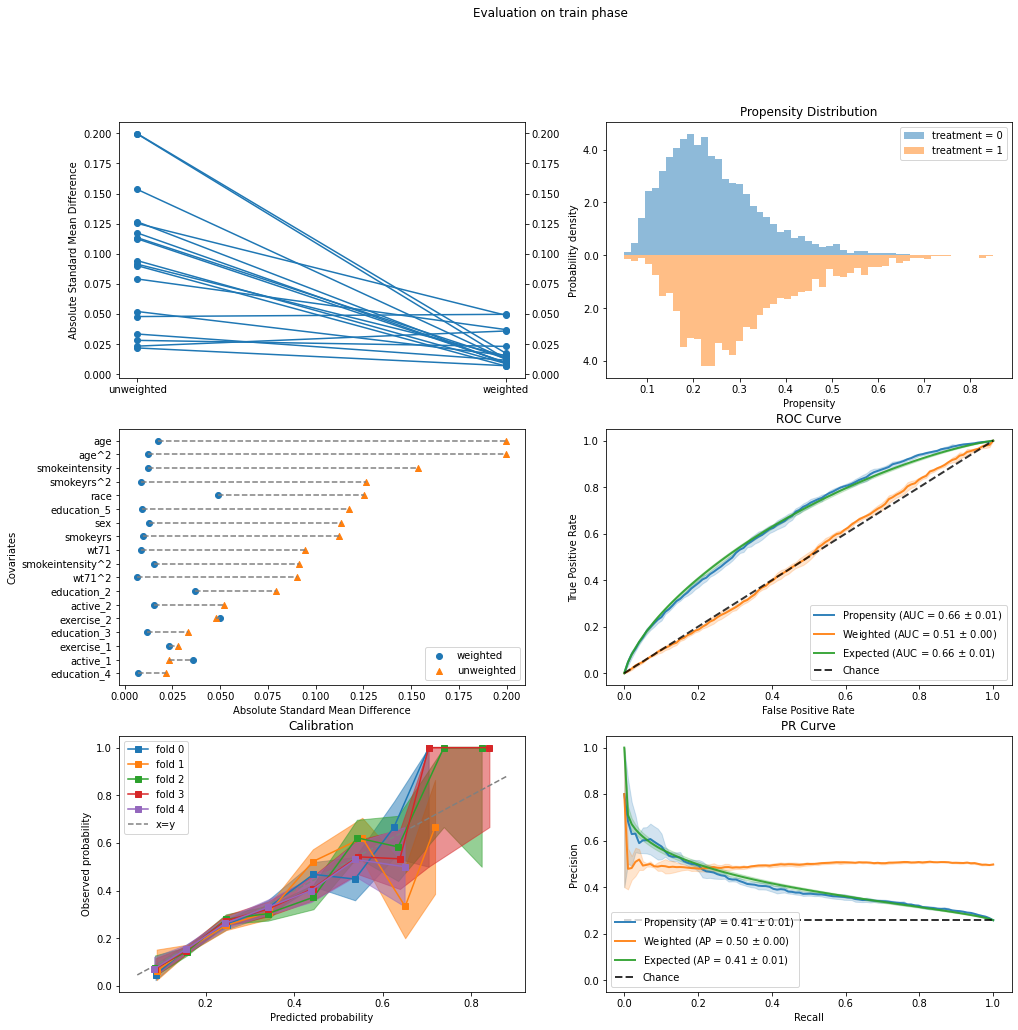

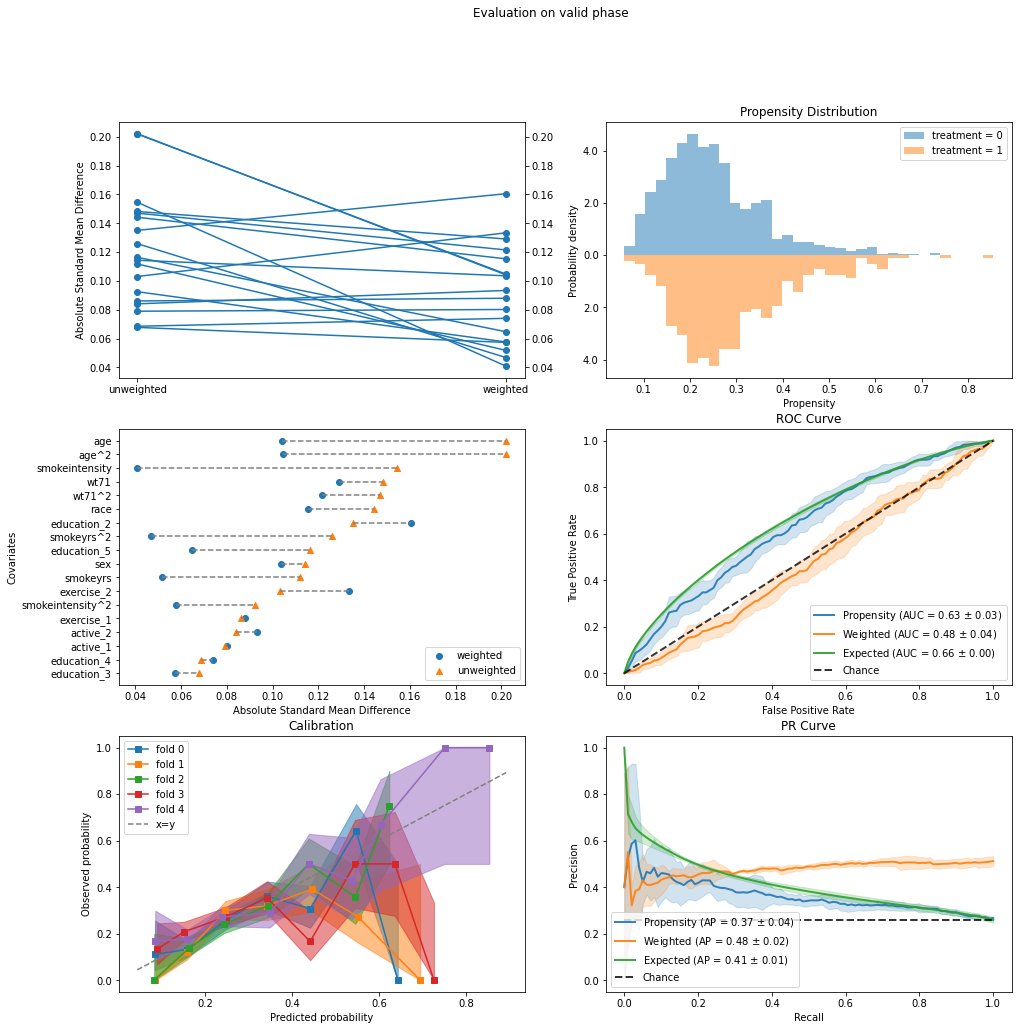

In [9]:
plot_axes = plot_evaluation_results(results)

With the current interface we do not need to type the strings in by hand, we can autocomplete them from the results attribute `plot_names`. This is a simple dataclass that maps to the string name. This approach typo-proofs the plot name. If plotting a single figure, you can also use kwargs which will be passed to the underlying plotting function. However, to look up which options are supported still requires looking up the plotting function in `plots.py`.

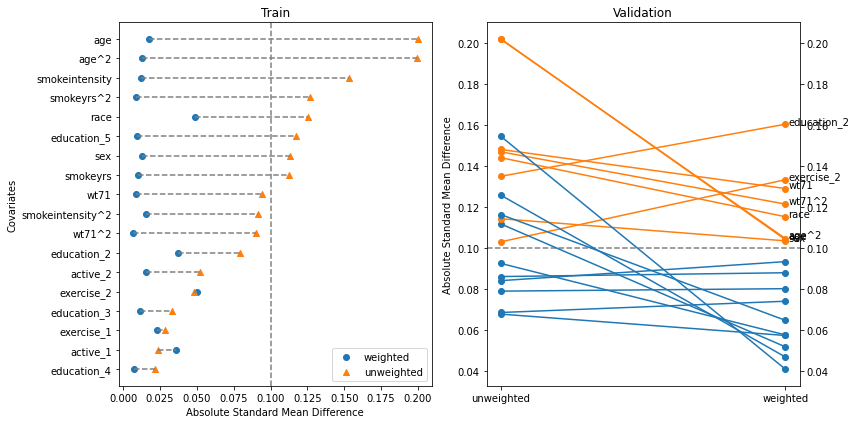

In [10]:
from matplotlib import pyplot as plt

fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 6))
results.plot_covariate_balance(phase="train", ax=a0, thresh=0.1)
results.plot_covariate_balance(kind="slope", phase="valid", ax=a1, thresh=0.1)
a0.set_title("Train")
a1.set_title("Validation")
plt.tight_layout();

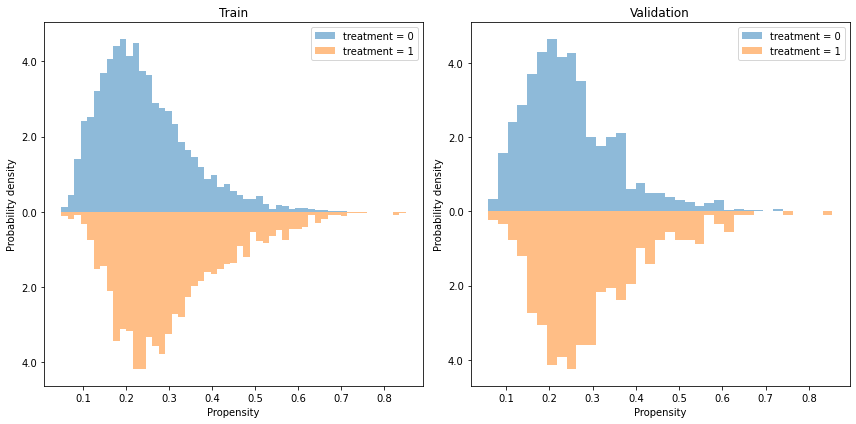

In [11]:
fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 6))
reflected = results.plot_weight_distribution(reflect=True, ax=a0)
not_reflected = results.plot_weight_distribution(reflect=True, phase="valid", ax=a1)
a0.set_title("Train")
a1.set_title("Validation")
plt.tight_layout();

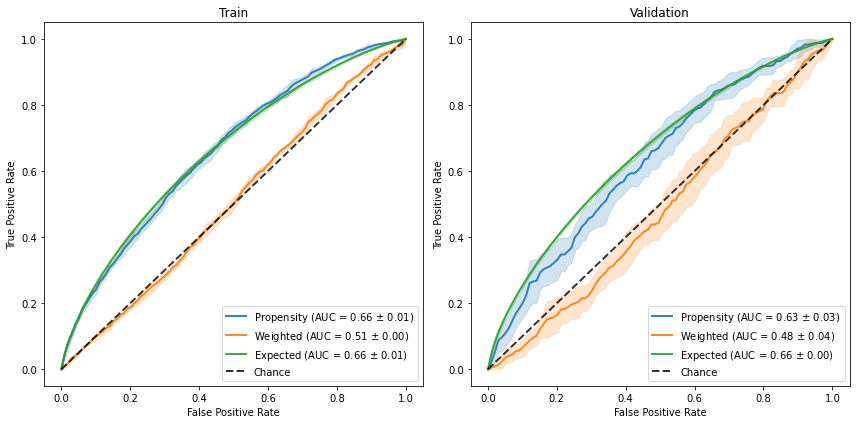

In [12]:
fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 6))
results.plot_roc_curve(ax=a0)
results.plot_roc_curve(phase="valid", ax=a1)
a0.set_title("Train")
a1.set_title("Validation")
plt.tight_layout();

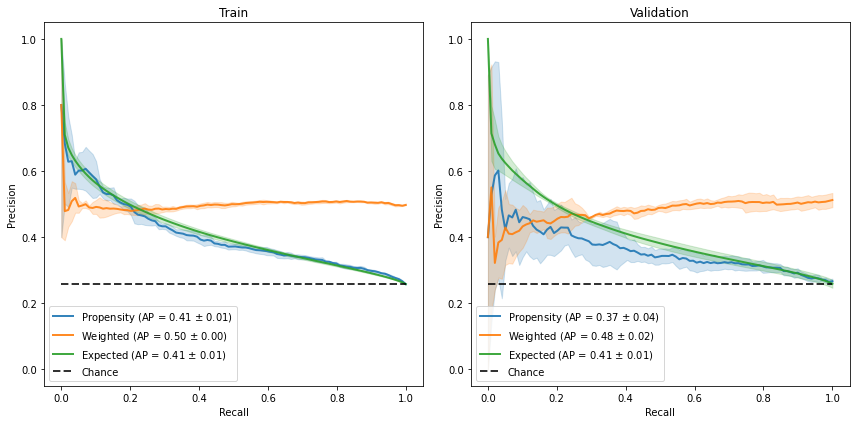

In [13]:
fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 6))
results.plot_pr_curve(ax=a0)
results.plot_pr_curve(phase="valid", ax=a1)
a0.set_title("Train")
a1.set_title("Validation")
plt.tight_layout();

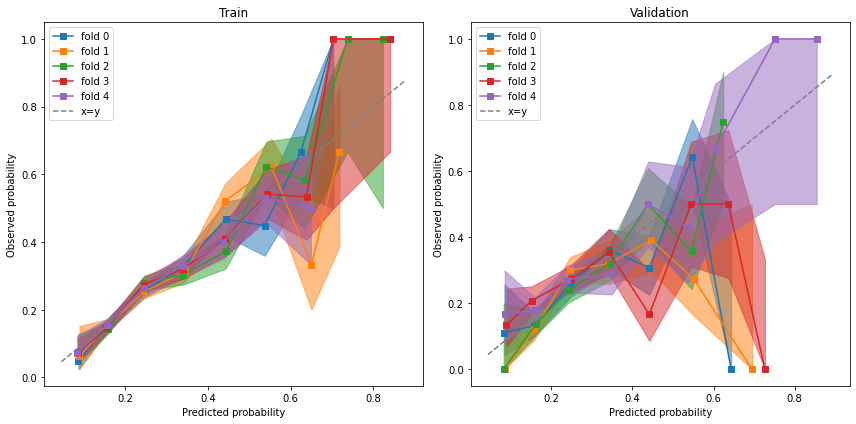

In [14]:
fig, [a0, a1] = plt.subplots(1, 2, figsize=(12, 6))
results.plot_calibration_curve(ax=a0)
results.plot_calibration_curve(phase="valid", ax=a1)
a0.set_title("Train")
a1.set_title("Validation")
plt.tight_layout();

## Testing outcome plots

### Continuous outcomes

In [15]:
continuous_outcome_plots = [
    "continuous_accuracy",
    "common_support",
    "residuals",
]

In [16]:
cont_std = StratifiedStandardization(LinearRegression())
cont_std.fit(data.X, data.a, data.y)

StratifiedStandardization(learner=LinearRegression())

In [17]:
cont_outcome_results = evaluate(cont_std, data.X, data.a, data.y)

In [18]:
assert cont_outcome_results.all_plot_names == set(continuous_outcome_plots)

{'train': {'continuous_accuracy': <AxesSubplot:title={'center':'Continuous Accuracy Plot'}, xlabel='Predicted values', ylabel='True values'>,
  'residuals': <AxesSubplot:title={'center':'Residual Plot'}, xlabel='Predicted values', ylabel='Prediction residuals'>,
  'common_support': <AxesSubplot:title={'center':'Predicted Common Support'}, xlabel='Predicted $Y^0$', ylabel='Predicted $Y^1$'>}}

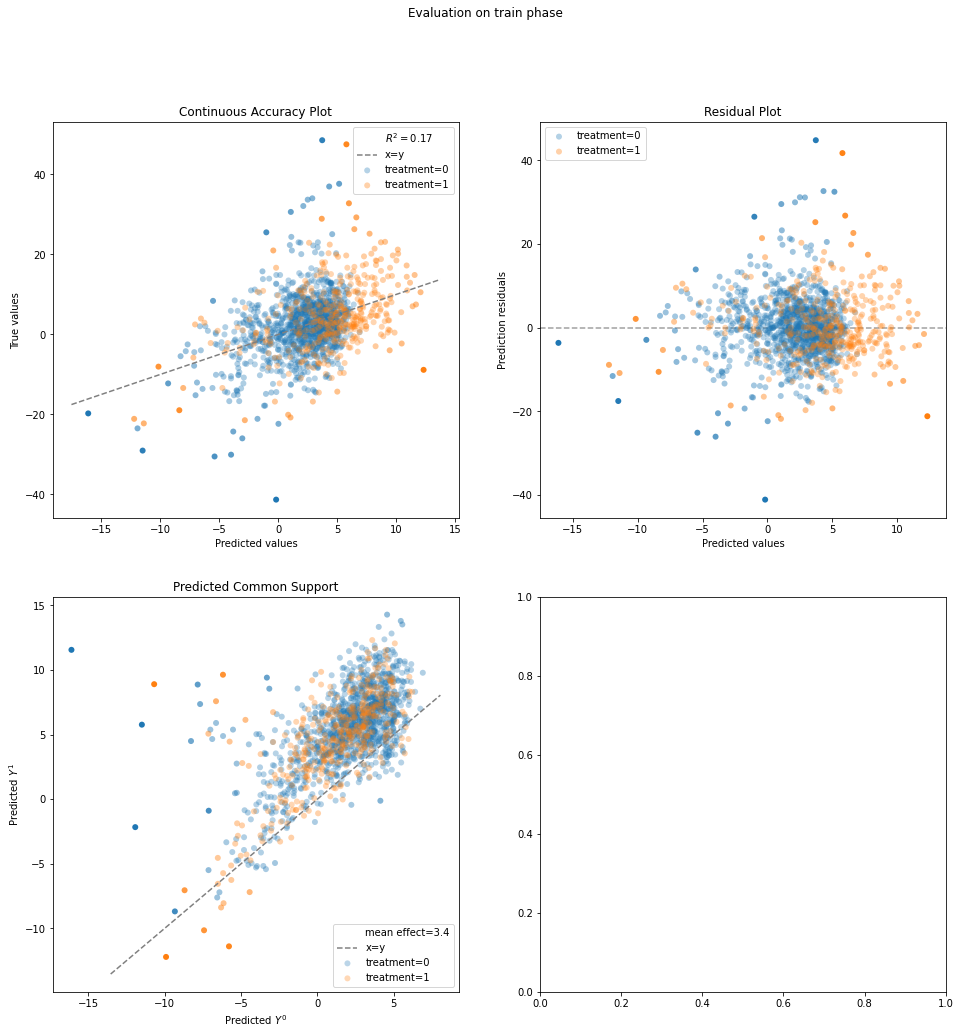

In [19]:
plot_evaluation_results(cont_outcome_results)

### Binary outcomes

In [20]:
import numpy as np
import pandas as pd

In [21]:
binary_outcome_plots = [
    "calibration",
    "roc_curve",
    "pr_curve",
]

In [22]:
y = 1 / (1 + np.exp(-data.y))
y = np.random.binomial(1, y)
y = pd.Series(y, index=data.a.index)

In [23]:
bin_std = StratifiedStandardization(LogisticRegression(max_iter=2000))
bin_std.fit(data.X, data.a, y)

StratifiedStandardization(learner=LogisticRegression(max_iter=2000))

In [24]:
bin_outcome_results = evaluate(bin_std, data.X, data.a, y)

In [25]:
assert bin_outcome_results.all_plot_names == set(binary_outcome_plots)

{'train': {'calibration': <AxesSubplot:title={'center':'Calibration'}, xlabel='Predicted probability', ylabel='Observed probability'>,
  'pr_curve': <AxesSubplot:title={'center':'PR Curve'}, xlabel='Recall', ylabel='Precision'>,
  'roc_curve': <AxesSubplot:title={'center':'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>}}

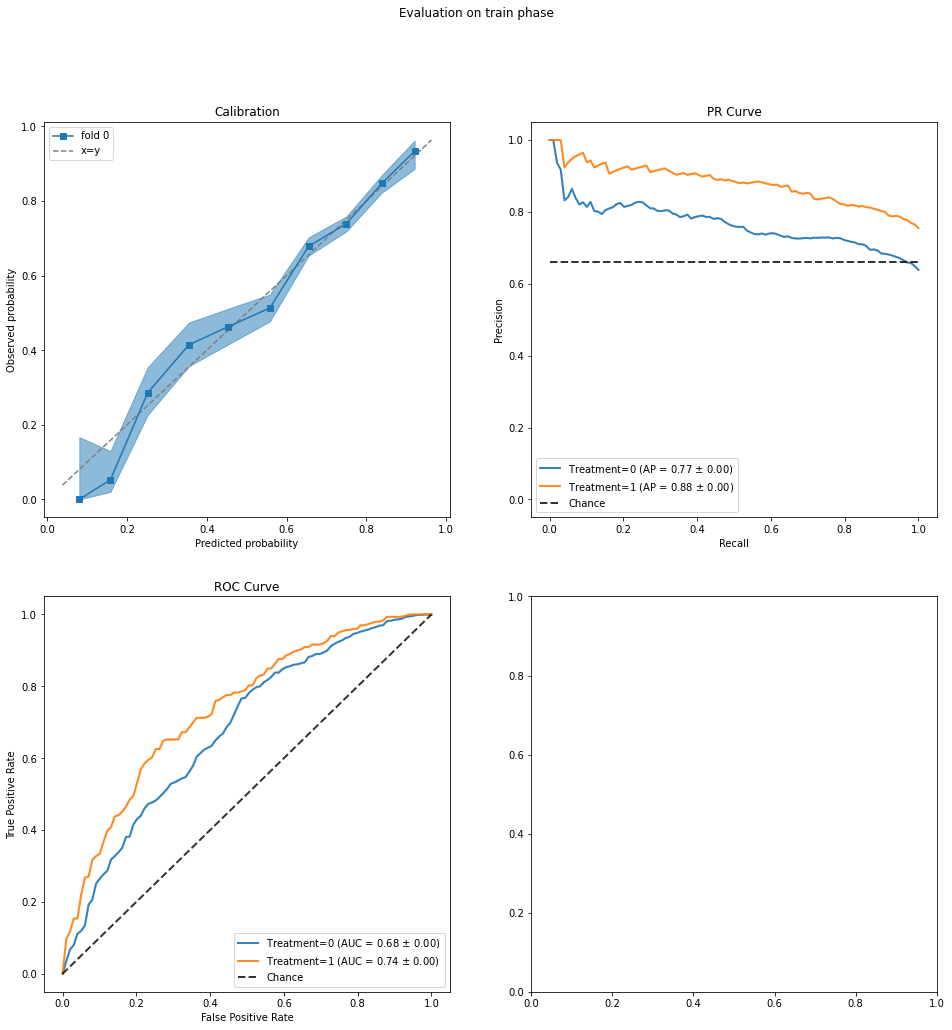

In [26]:
plot_evaluation_results(bin_outcome_results)

## Cross validation plotting

### IPW

{'train': {'covariate_balance_slope': <AxesSubplot:ylabel='Absolute Standard Mean Difference'>,
  'weight_distribution': <AxesSubplot:title={'center':'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>,
  'covariate_balance_love': <AxesSubplot:xlabel='Absolute Standard Mean Difference', ylabel='Covariates'>,
  'roc_curve': <AxesSubplot:title={'center':'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>,
  'calibration': <AxesSubplot:title={'center':'Calibration'}, xlabel='Predicted probability', ylabel='Observed probability'>,
  'pr_curve': <AxesSubplot:title={'center':'PR Curve'}, xlabel='Recall', ylabel='Precision'>},
 'valid': {'covariate_balance_slope': <AxesSubplot:ylabel='Absolute Standard Mean Difference'>,
  'weight_distribution': <AxesSubplot:title={'center':'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>,
  'covariate_balance_love': <AxesSubplot:xlabel='Absolute Standard Mean Difference', ylabel='C

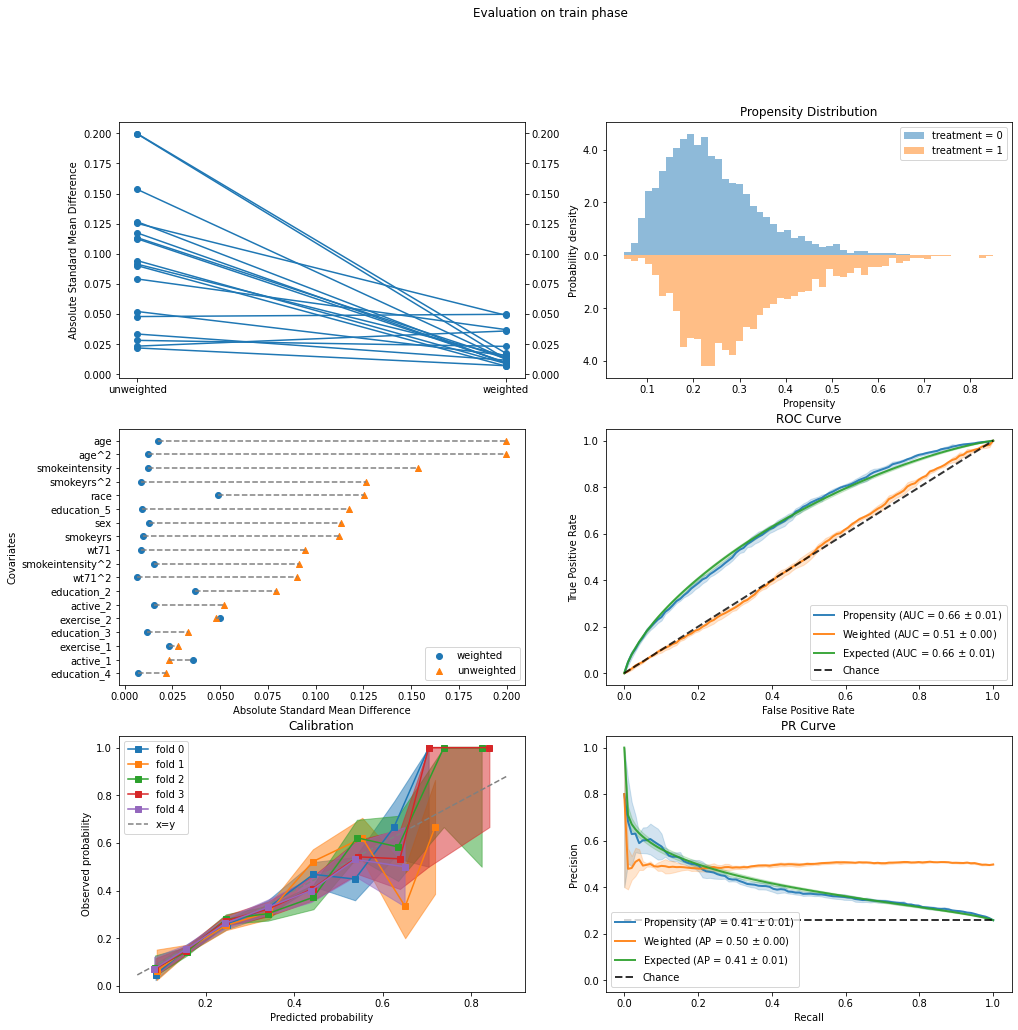

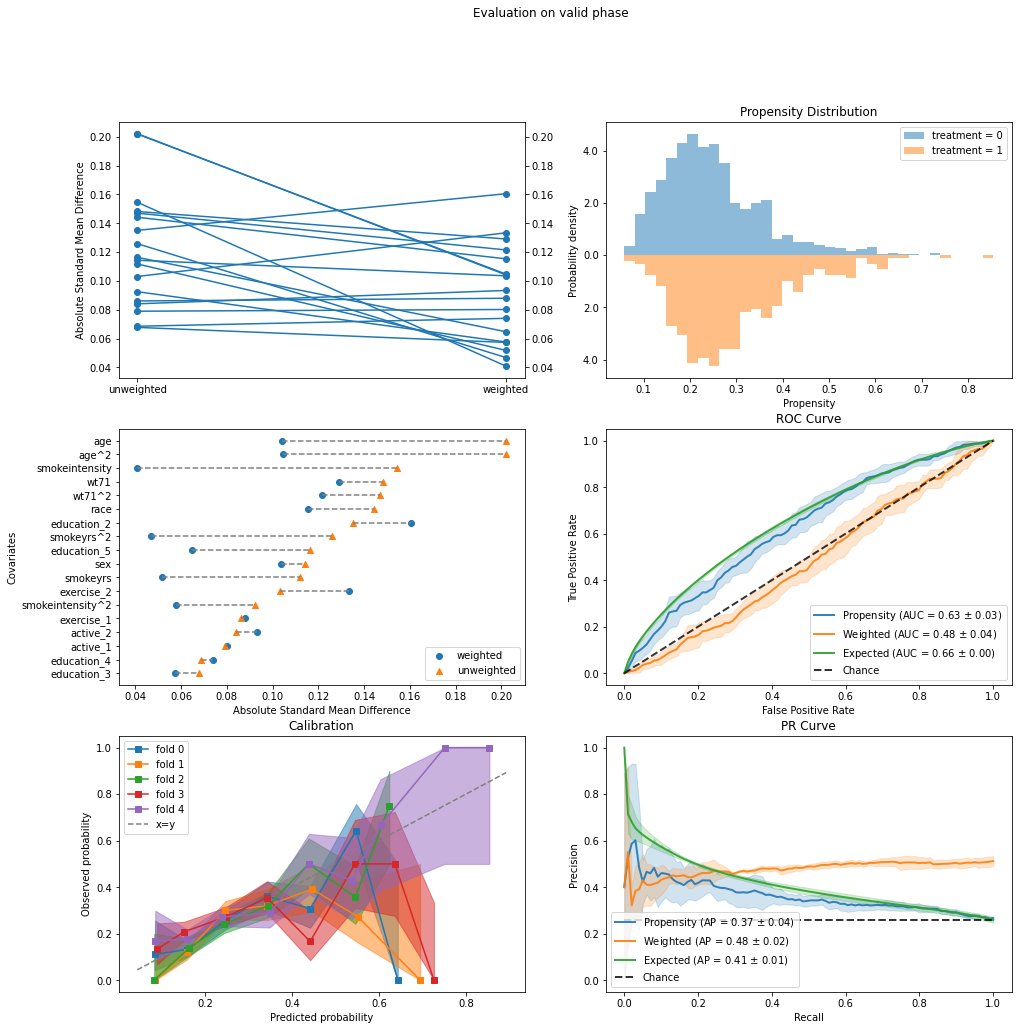

In [27]:
prop_results_cv = evaluate(ipw, data.X, data.a, data.y, cv="auto")
assert prop_results_cv.all_plot_names == set(propensity_plots)
plot_evaluation_results(prop_results_cv)

### Continuous outcome plots

{'train': {'continuous_accuracy': <AxesSubplot:title={'center':'Continuous Accuracy Plot'}, xlabel='Predicted values', ylabel='True values'>,
  'residuals': <AxesSubplot:title={'center':'Residual Plot'}, xlabel='Predicted values', ylabel='Prediction residuals'>,
  'common_support': <AxesSubplot:title={'center':'Predicted Common Support'}, xlabel='Predicted $Y^0$', ylabel='Predicted $Y^1$'>},
 'valid': {'continuous_accuracy': <AxesSubplot:title={'center':'Continuous Accuracy Plot'}, xlabel='Predicted values', ylabel='True values'>,
  'residuals': <AxesSubplot:title={'center':'Residual Plot'}, xlabel='Predicted values', ylabel='Prediction residuals'>,
  'common_support': <AxesSubplot:title={'center':'Predicted Common Support'}, xlabel='Predicted $Y^0$', ylabel='Predicted $Y^1$'>}}

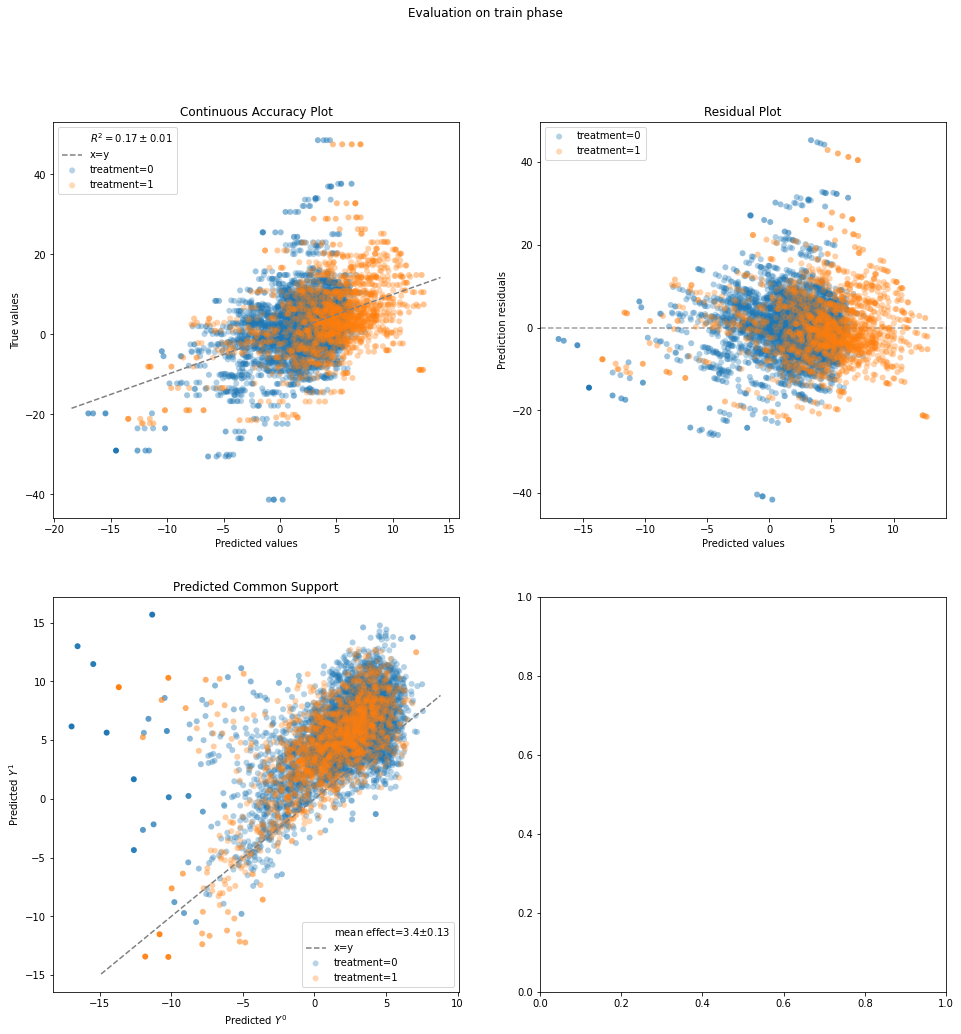

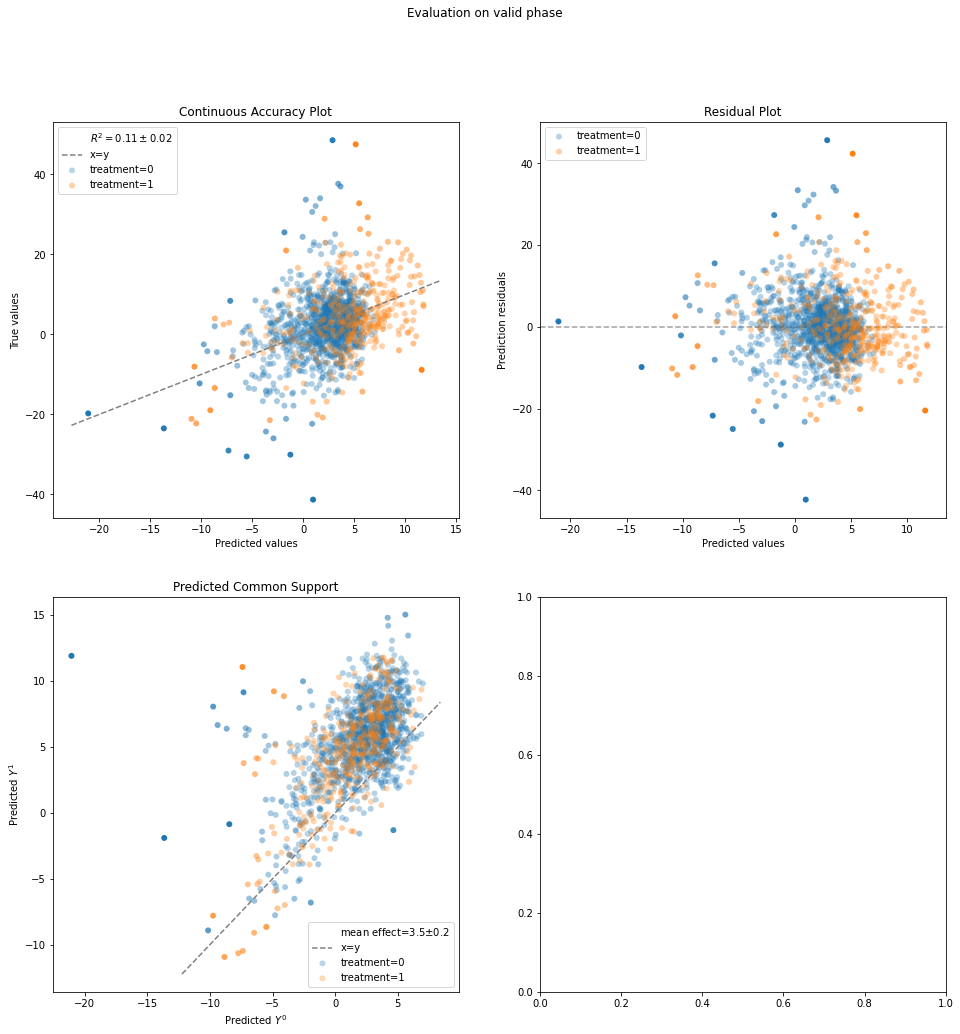

In [28]:
cont_outcome_cv_results = evaluate(cont_std, data.X, data.a, data.y, cv="auto")
assert cont_outcome_cv_results.all_plot_names == set(continuous_outcome_plots)
plot_evaluation_results(cont_outcome_cv_results)

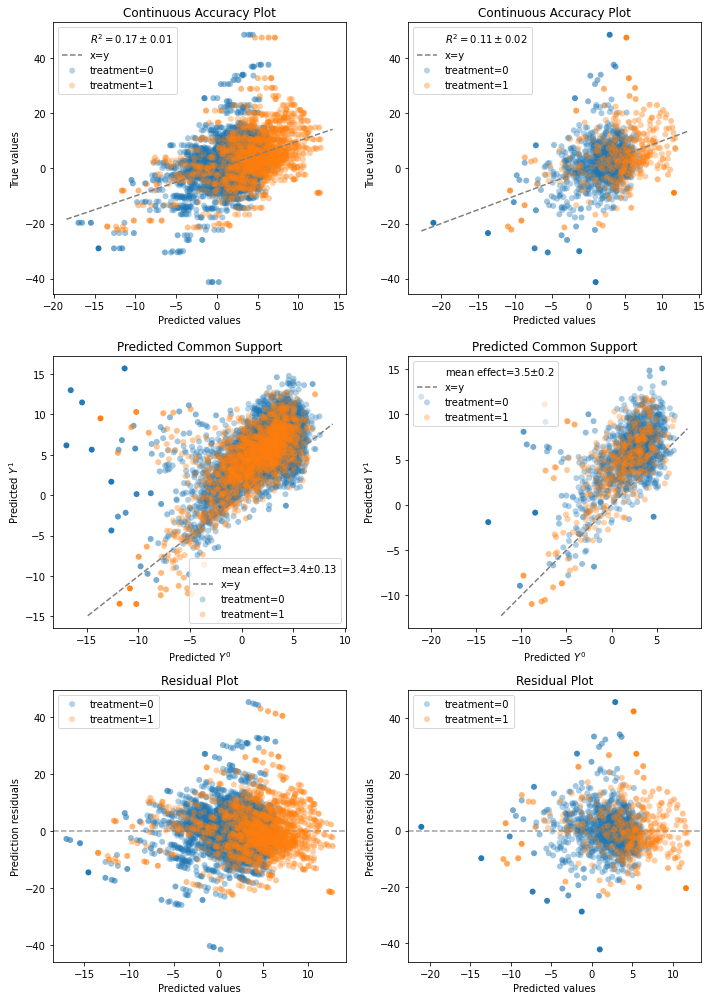

In [29]:
f, axes = plt.subplots(3, 2, figsize=(10, 14))
row1, row2, row3 = axes
cont_outcome_cv_results.plot_continuous_accuracy(phase="train", ax=row1[0])
cont_outcome_cv_results.plot_continuous_accuracy(phase="valid", ax=row1[1])
cont_outcome_cv_results.plot_common_support(phase="train", ax=row2[0])
cont_outcome_cv_results.plot_common_support(phase="valid", ax=row2[1])
cont_outcome_cv_results.plot_residuals(phase="train", ax=row3[0])
cont_outcome_cv_results.plot_residuals(phase="valid", ax=row3[1])
plt.tight_layout()

### Binary outcome plots

{'train': {'calibration': <AxesSubplot:title={'center':'Calibration'}, xlabel='Predicted probability', ylabel='Observed probability'>,
  'pr_curve': <AxesSubplot:title={'center':'PR Curve'}, xlabel='Recall', ylabel='Precision'>,
  'roc_curve': <AxesSubplot:title={'center':'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>},
 'valid': {'calibration': <AxesSubplot:title={'center':'Calibration'}, xlabel='Predicted probability', ylabel='Observed probability'>,
  'pr_curve': <AxesSubplot:title={'center':'PR Curve'}, xlabel='Recall', ylabel='Precision'>,
  'roc_curve': <AxesSubplot:title={'center':'ROC Curve'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>}}

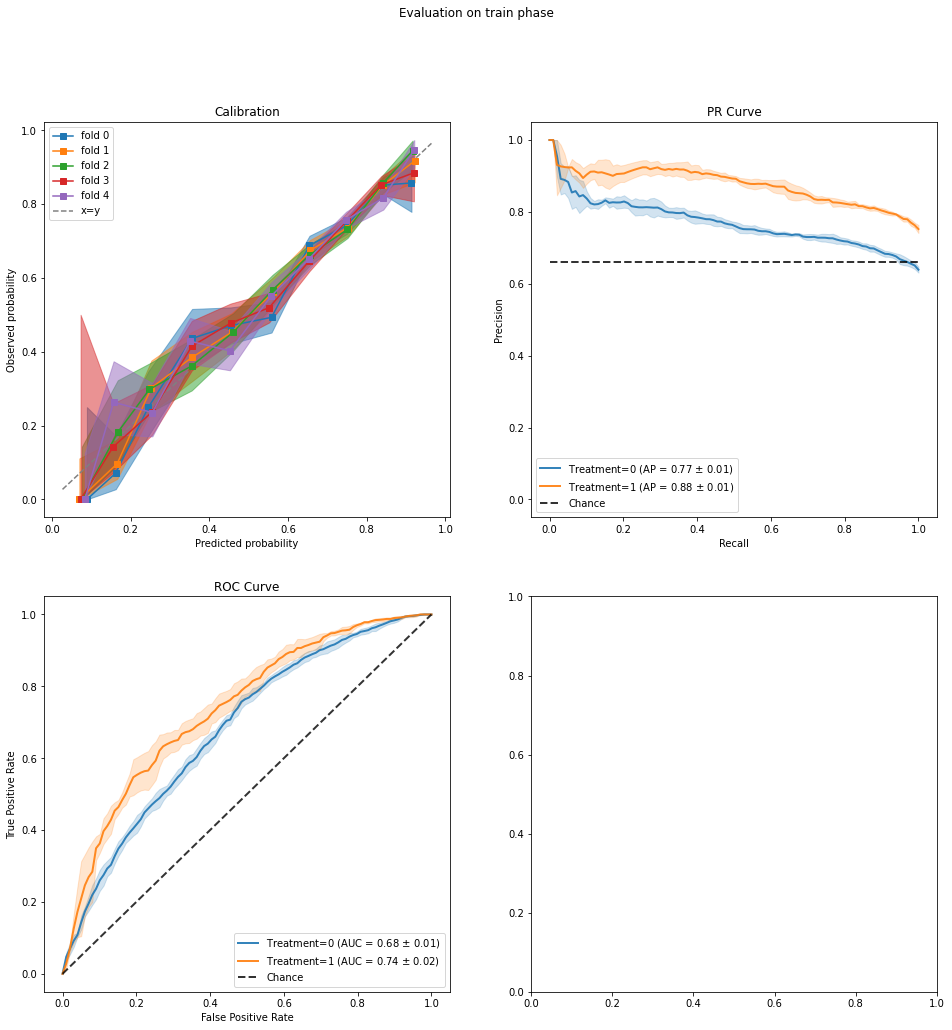

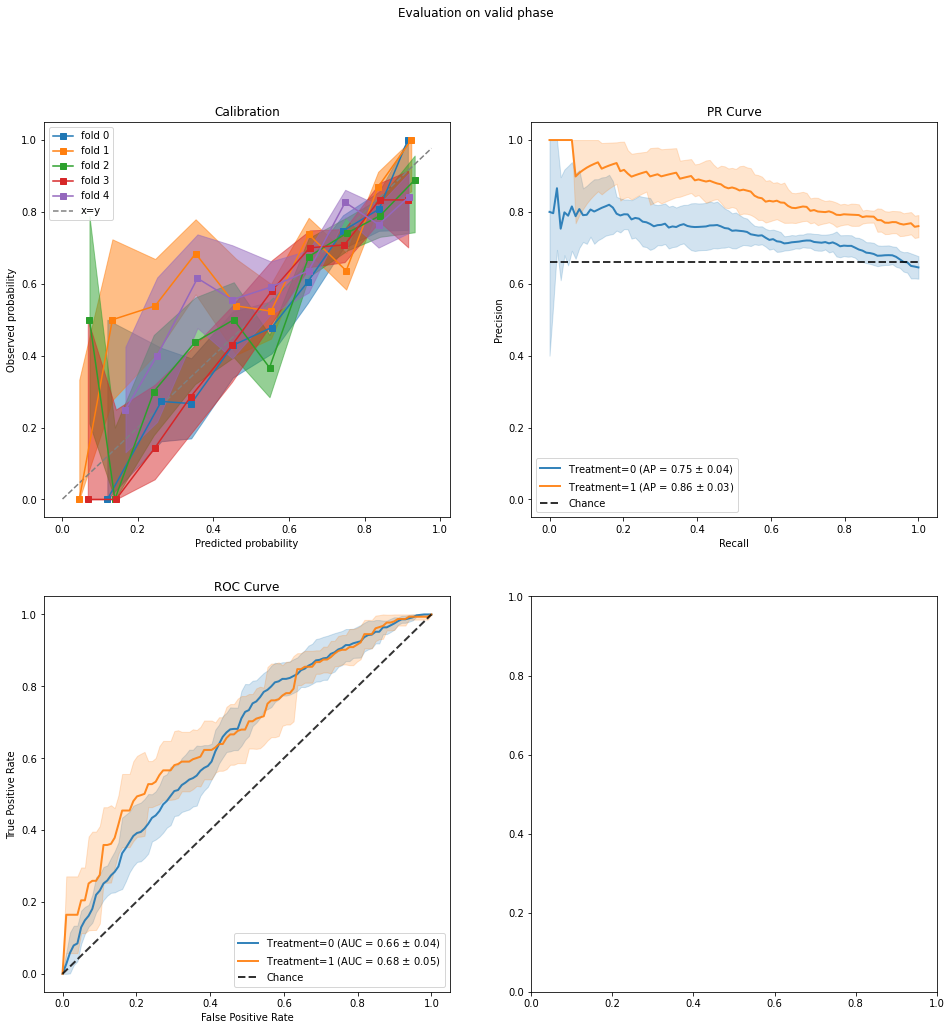

In [30]:
bin_outcome_cv_results = evaluate(bin_std, data.X, data.a, y, cv="auto")
assert bin_outcome_cv_results.all_plot_names == set(binary_outcome_plots)
plot_evaluation_results(bin_outcome_cv_results)